In [22]:
#Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings
warnings.filterwarnings('ignore')


# Set seaborn style
sns.set(style='whitegrid', palette="husl")

# Load dataset
df = pd.read_csv(r'C:\Users\nirun\OneDrive\Desktop\2025-Y2-S1-MLB-B6G1-05-PGNO-105\data\raw\heart_disease_risk.csv')

#Basic info
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

# Identify numerical columns that are likely categorical
suspected_categorical = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 10:
        unique_vals = sorted(df[col].unique())
        print(f"\n{col}: {unique_vals} (likely categorical)")
        suspected_categorical.append(col)

print(f"\nSuspected categorical features: {suspected_categorical}")

Dataset shape: (70000, 19)

Data types:
Chest_Pain             float64
Shortness_of_Breath    float64
Fatigue                float64
Palpitations           float64
Dizziness              float64
Swelling               float64
Pain_Arms_Jaw_Back     float64
Cold_Sweats_Nausea     float64
High_BP                float64
High_Cholesterol       float64
Diabetes               float64
Smoking                float64
Obesity                float64
Sedentary_Lifestyle    float64
Family_History         float64
Chronic_Stress         float64
Gender                 float64
Age                    float64
Heart_Risk             float64
dtype: object

Chest_Pain: [0.0, 1.0] (likely categorical)

Shortness_of_Breath: [0.0, 1.0] (likely categorical)

Fatigue: [0.0, 1.0] (likely categorical)

Palpitations: [0.0, 1.0] (likely categorical)

Dizziness: [0.0, 1.0] (likely categorical)

Swelling: [0.0, 1.0] (likely categorical)

Pain_Arms_Jaw_Back: [0.0, 1.0] (likely categorical)

Cold_Sweats_Nausea: [0.0, 1.

In [23]:
# Copy dataframe for interpreted labels
df_interpreted = df.copy()


# Example mappings (only for binary and chest pain)
categorical_mappings = {
    'Gender': {0: 'Female', 1: 'Male'},
    'Smoking': {0: 'No', 1: 'Yes'},
    'Diabetes': {0: 'No', 1: 'Yes'},
    'High_BP': {0: 'No', 1: 'Yes'},
    'High_Cholesterol': {0: 'No', 1: 'Yes'},
    'Obesity': {0: 'No', 1: 'Yes'},
    'Sedentary_Lifestyle': {0: 'No', 1: 'Yes'},
    'Family_History': {0: 'No', 1: 'Yes'},
    'Chronic_Stress': {0: 'No', 1: 'Yes'},
    'Chest_Pain': {0: 'Typical', 1: 'Atypical', 2: 'Non-anginal', 3: 'Asymptomatic'},
    'Heart_Risk': {0: 'Low', 1: 'High'}
}

# Apply reverse mapping to create interpretable categories
for col, mapping in categorical_mappings.items():
    if col in df.columns:
        df_interpreted[f'{col}_Label'] = df[col].map(mapping)
        print(f"Created {col}_Label from {col}")

Created Gender_Label from Gender
Created Smoking_Label from Smoking
Created Diabetes_Label from Diabetes
Created High_BP_Label from High_BP
Created High_Cholesterol_Label from High_Cholesterol
Created Obesity_Label from Obesity
Created Sedentary_Lifestyle_Label from Sedentary_Lifestyle
Created Family_History_Label from Family_History
Created Chronic_Stress_Label from Chronic_Stress
Created Chest_Pain_Label from Chest_Pain
Created Heart_Risk_Label from Heart_Risk


In [24]:
# Now demonstrate various encoding methods
print("=== ENCODING DEMONSTRATION ===")

# 1. Label Encoding (already applied for binary features)
binary_features = [c for c in suspected_categorical if df[c].nunique() == 2]
for col in binary_features:
    print(f"{col}: {df[col].unique()} (binary)")

# 2. One-Hot Encoding example for Chest_Pain (multi-class)
if 'Chest_Pain' in df.columns:
    chest_pain_onehot = pd.get_dummies(df_interpreted['Chest_Pain_Label'], prefix='Chest_Pain', drop_first=True)
    print("\nOne-Hot Encoding Demo for Chest_Pain:")
    print(chest_pain_onehot.head())

# 3. Ordinal Encoding – Not applicable (no ordinal categorical in your dataset)
print("\nOrdinal Encoding Example: (Not applicable in this dataset)")


=== ENCODING DEMONSTRATION ===
Chest_Pain: [0. 1.] (binary)
Shortness_of_Breath: [0. 1.] (binary)
Fatigue: [0. 1.] (binary)
Palpitations: [1. 0.] (binary)
Dizziness: [0. 1.] (binary)
Swelling: [0. 1.] (binary)
Pain_Arms_Jaw_Back: [0. 1.] (binary)
Cold_Sweats_Nausea: [0. 1.] (binary)
High_BP: [0. 1.] (binary)
High_Cholesterol: [0. 1.] (binary)
Diabetes: [0. 1.] (binary)
Smoking: [1. 0.] (binary)
Obesity: [0. 1.] (binary)
Sedentary_Lifestyle: [1. 0.] (binary)
Family_History: [0. 1.] (binary)
Chronic_Stress: [0. 1.] (binary)
Gender: [0. 1.] (binary)
Heart_Risk: [0. 1.] (binary)

One-Hot Encoding Demo for Chest_Pain:
   Chest_Pain_Typical
0                True
1                True
2               False
3               False
4                True

Ordinal Encoding Example: (Not applicable in this dataset)


In [25]:
#Encoding Comparison
print("\n=== ENCODING COMPARISON ===")

# Original categorical subset
original_categorical = df[suspected_categorical]

# One-hot encode all interpreted categorical labels
label_cols = [col+'_Label' for col in categorical_mappings.keys() if col+'_Label' in df_interpreted.columns]
df_onehot = pd.get_dummies(df_interpreted[label_cols], drop_first=True)

print(f"Original shape: {original_categorical.shape}")
print(f"One-hot shape: {df_onehot.shape}")
print(f"Memory usage - Original: {original_categorical.memory_usage(deep=True).sum()} bytes")
print(f"Memory usage - One-hot: {df_onehot.memory_usage(deep=True).sum()} bytes")



=== ENCODING COMPARISON ===
Original shape: (70000, 18)
One-hot shape: (70000, 11)
Memory usage - Original: 10080132 bytes
Memory usage - One-hot: 770132 bytes


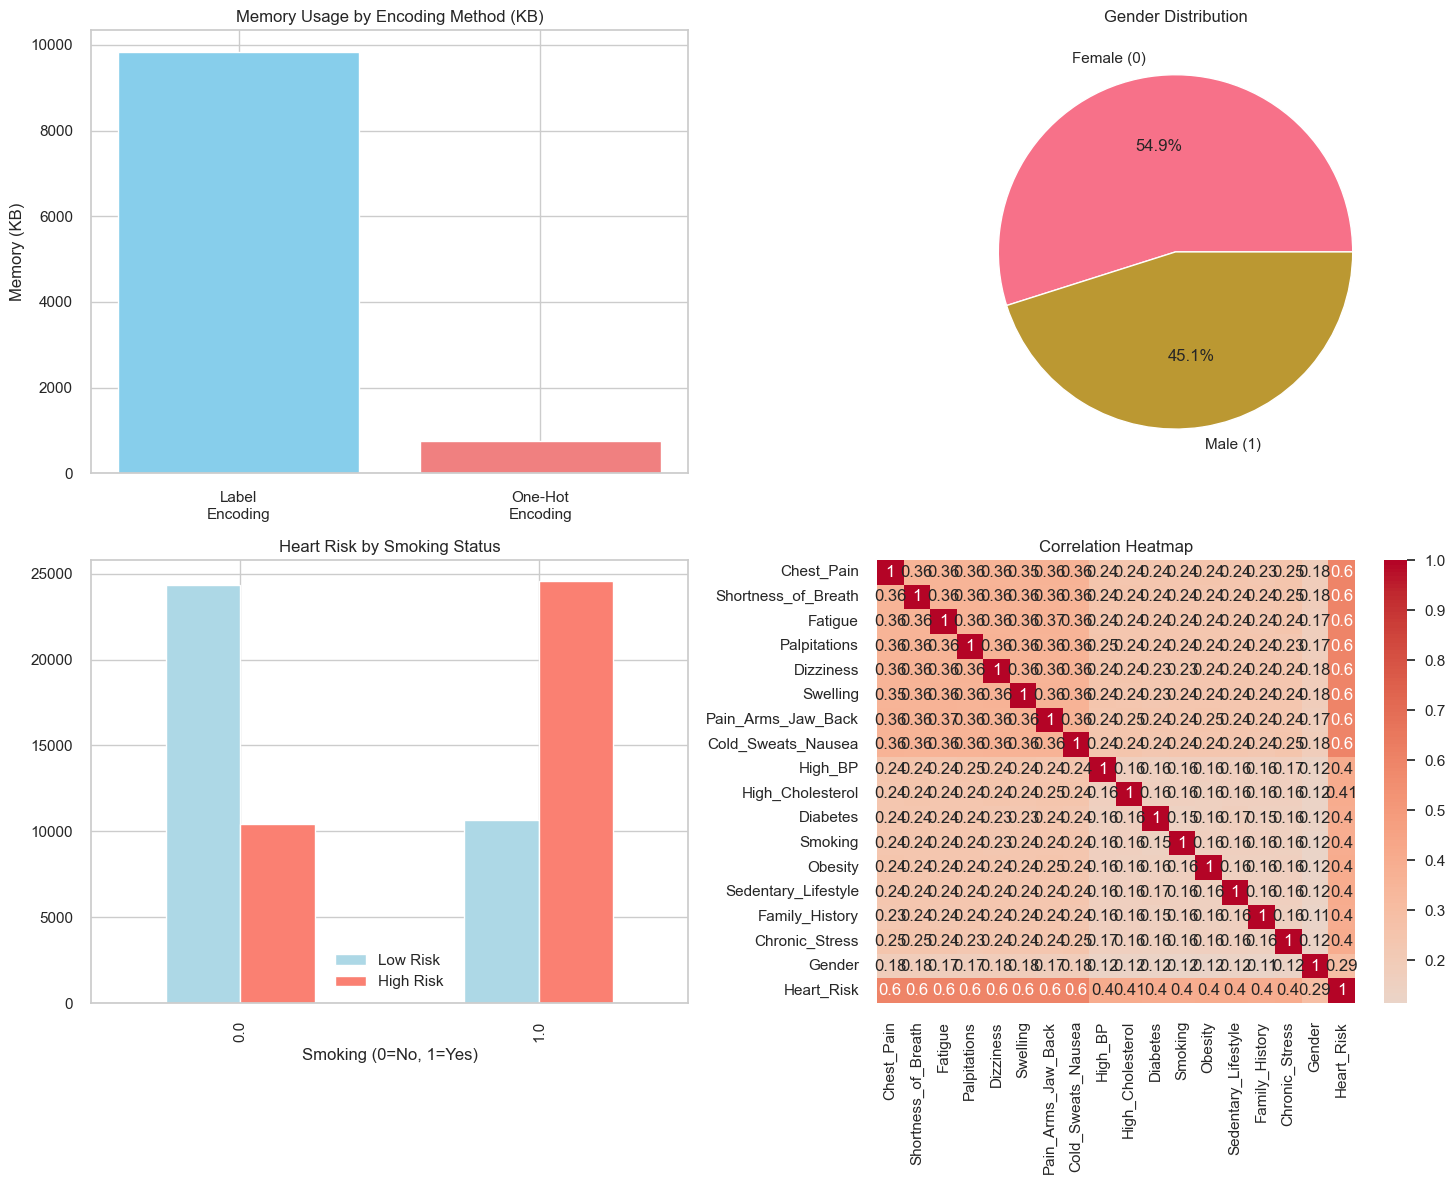

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Memory Usage by Encoding
methods = ['Label\nEncoding', 'One-Hot\nEncoding']
memory_usage = [
    original_categorical.memory_usage(deep=True).sum()/1024,
    df_onehot.memory_usage(deep=True).sum()/1024
]
axes[0,0].bar(methods, memory_usage, color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Memory Usage by Encoding Method (KB)')
axes[0,0].set_ylabel('Memory (KB)')

# 2. Gender Distribution
if 'Gender' in df.columns:
    gender_dist = df['Gender'].value_counts()
    axes[0,1].pie(gender_dist.values, labels=['Female (0)', 'Male (1)'], autopct='%1.1f%%')
    axes[0,1].set_title('Gender Distribution')

# 3. Heart Risk by Smoking
if 'Smoking' in df.columns and 'Heart_Risk' in df.columns:
    smoking_risk = pd.crosstab(df['Smoking'], df['Heart_Risk'])
    smoking_risk.plot(kind='bar', ax=axes[1,0], color=['lightblue','salmon'])
    axes[1,0].set_title('Heart Risk by Smoking Status')
    axes[1,0].set_xlabel('Smoking (0=No, 1=Yes)')
    axes[1,0].legend(['Low Risk','High Risk'])

# 4. Correlation Heatmap
if len(suspected_categorical) >= 3 and 'Heart_Risk' in df.columns:
    corr_matrix = df[suspected_categorical].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('Correlation Heatmap')

plt.tight_layout()
plt.savefig('../results/eda_visualizations/categorical_encoding_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

